In [1]:
using Revise
using JLD2
using Plots; pyplot()
using LaTeXStrings
#using Interact

push!(LOAD_PATH, joinpath(pwd(), "src"))
using DifferentialPrivacy
using LinearBandits
using Experiments

In [2]:
addprocs()

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [16]:
#@everywhere using Revise
@everywhere using DifferentialPrivacy
@everywhere using LinearBandits
@everywhere using Experiments

# Experiment 1

$k = d^2$, optimal arm has reward 0.75, suboptimal arm rewards ${}\in[-0.75, 0.25]$, $T=d^2$, both Bernoulli rewards $\in \{-1, 1\}$ and Gaussian reward noise with $\sigma=1$.

In [17]:
exp1_dims = (round(Int, d) for d in logspace(log10(4), log10(32), 7))
exp1_env = EnvParams(dim=0, maxrewardmean=0.75, σ=1.0);
exp1_gap = 0.5
exp1_horizon = 5*10^5

@everywhere function experiment1(exp_env; ρ=1.0, gap=exp1_gap, horizon=exp1_horizon)
    function (dim)
        env = EnvParams(exp_env; dim=dim)
        alg = make_alg(env, horizon, ρ=ρ)
        arms = GapArms(env; gap=gap)
        regrets = run_episode(env, alg, arms, horizon; subsample=1)
        regrets.data[end]
    end
end

In [18]:
exp1a_env = exp1_env
exp1a_results = []

0-element Array{Any,1}

In [19]:
push!(exp1a_results,
    run_experiment(experiment1(exp1a_env), exp1_dims; runs=64));

Progress: 100%|█████████████████████████████████████████| Time: 3:33:20


In [20]:
exp1b_env = EnvParams(exp1_env; maxreward=1.0)
exp1b_results = []

0-element Array{Any,1}

In [21]:
push!(exp1b_results,
    run_experiment(experiment1(exp1b_env), exp1_dims; runs=64));

Progress: 100%|█████████████████████████████████████████| Time: 3:34:23


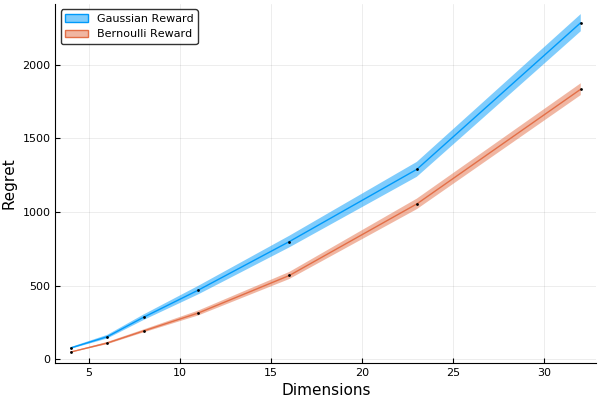

In [22]:
plot(hcat(exp1a_results...), label="Gaussian Reward")
plot!(hcat(exp1b_results...), label="Bernoulli Reward")
#plot!(hcat(exp1a_results...), xaxis=:log, yaxis=:log)
#plot!(hcat(exp1b_results...), xaxis=:log, yaxis=:log)
xlabel!("Dimensions")
ylabel!("Regret")

In [27]:
function loglog_regression(result::ExpResult)
    result = ExpResult(log10.(result.coords), log10.(result.data))
    x = repmat(result.coords, size(result.data, 2))
    y = vec(result.data)
    x_aug = [x ones(size(x))]
    (slope, intercept) = x_aug'x_aug \ x_aug'y
    @show slope, 10^intercept
    plot(result, label="")
    scatter!(x, y, label="")
    plot!(x -> slope*x + intercept, label=latexstring("\\hat{R}_n \\approx"*
            "$(round(10^intercept, 3)) \\cdot d^{$(round(slope, 3))}"))
    xlabel!(L"\log_{10}(d)")
    ylabel!(L"\log_{10}(\hat{R}_n)")
end

loglog_regression (generic function with 1 method)

(slope, 10 ^ intercept) = (1.7084116046136728, 6.2106368212191345)


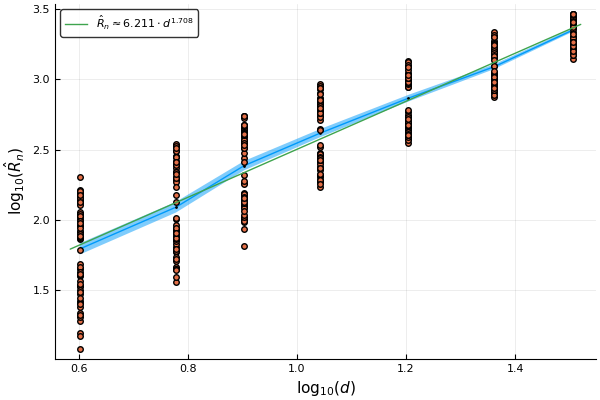

In [28]:
loglog_regression(hcat(exp1a_results...))

(slope, 10 ^ intercept) = (1.7720178393075272, 3.9901130251430104)


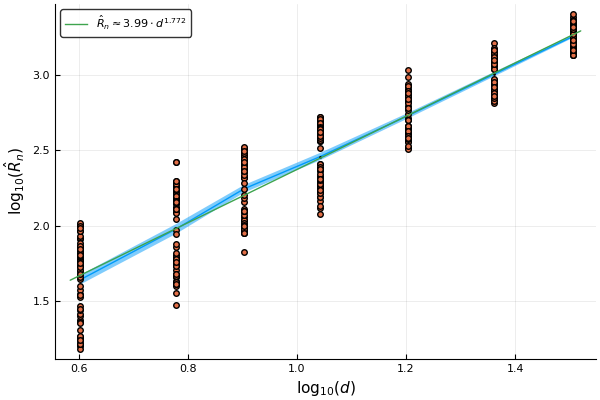

In [29]:
loglog_regression(hcat(exp1b_results...))

In [33]:
@save "data/exp1/results_$(now()).jld" exp1_gap exp1_horizon exp1a_env exp1a_results exp1b_env exp1b_results

In [8]:
@load "data/exp1/results.jld"

6-element Array{Symbol,1}:
 :exp1_dims    
 :exp1_horizon 
 :exp1a_env    
 :exp1a_results
 :exp1b_env    
 :exp1b_results

# Experiment 2

$k = d^2$, optimal arm has reward 0.75, suboptimal arm rewards ${}\in[-0.75, 0.25]$, $T=d^2$, Bernoulli rewards $\in \{-1, 1\}$, pan-private tree mechanism with Wishart noise, maintaining $(1, 0.1)$-differential privacy.

In [44]:
exp2_horizon = 10^6;
exp2_env = EnvParams(dim=20, maxrewardmean=0.75, maxreward=1.0);
exp2_arms = GapArms(exp2_env; gap=0.5)
alg2a = make_alg(exp2_env, exp2_horizon; ρ=1.0);
alg2b = make_private_alg(exp2_env, exp2_horizon, 1.0, 0.1, WishartMechanism)
alg2c = make_private_alg(exp2_env, exp2_horizon, 1.0, 0.1, GaussianMechanism);
@show exp2_env;

exp2_env = LinearBandits.EnvParams
  dim: Int64 20
  maxθnorm: Float64 1.0
  maxactionnorm: Float64 1.0
  maxrewardmean: Float64 0.75
  maxreward: Float64 1.0
  σ: Float64 1.0



In [45]:
exp2a_results = []

0-element Array{Any,1}

In [48]:
append!(exp2a_results,
    pmap_progress(1:32) do _
        run_episode(exp2_env, alg2a, exp2_arms, exp2_horizon;
            subsample=100)
    end);

Progress: 100%|█████████████████████████████████████████| Time: 0:32:15


In [46]:
exp2b_results = []

0-element Array{Any,1}

In [49]:
append!(exp2b_results,
    pmap_progress(1:32) do _
        run_episode(exp2_env, alg2b, exp2_arms, exp2_horizon;
            subsample=100)
    end);

Progress: 100%|█████████████████████████████████████████| Time: 0:38:18


In [47]:
exp2c_results = []

0-element Array{Any,1}

In [50]:
append!(exp2c_results,
    pmap_progress(1:32) do _
        run_episode(exp2_env, alg2c, exp2_arms, exp2_horizon;
            subsample=100)
    end);

Progress: 100%|█████████████████████████████████████████| Time: 0:37:09


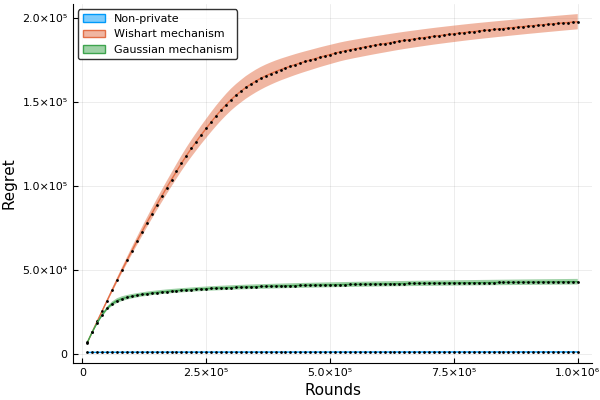

In [66]:
plot(hcat(exp2a_results...), label="Non-private")
plot!(hcat(exp2b_results...), label="Wishart mechanism")
plot!(hcat(exp2c_results...), label="Gaussian mechanism")
yaxis!("Regret")
xaxis!("Rounds")

In [67]:
@save "data/exp2/results_$(now()).jld" exp2_env exp2_arms exp2a_results exp2b_results exp2c_results